In [36]:
import os
import pandas as pd

# Hardcoded directories for 'yes' and 'no'
yes_dir = '/Users/yannietchi/Desktop/comp-562-final-project/MRI data/yes'
no_dir = '/Users/yannietchi/Desktop/comp-562-final-project/MRI data/no'


Sample images from 'yes' (Tumor) dataset:


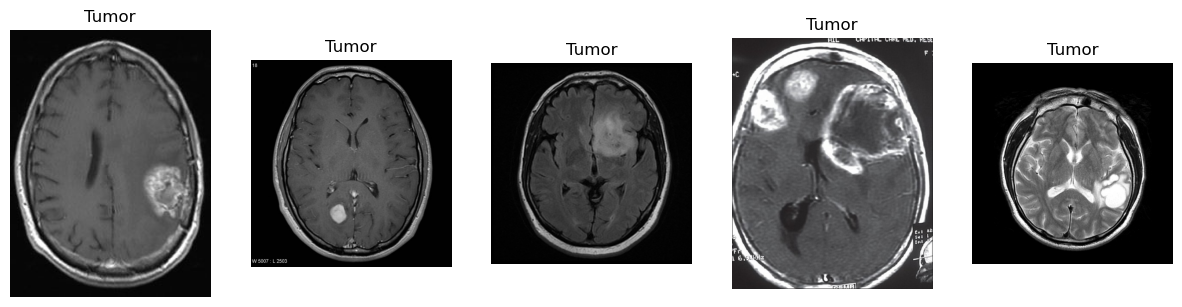

Sample images from 'no' (No Tumor) dataset:


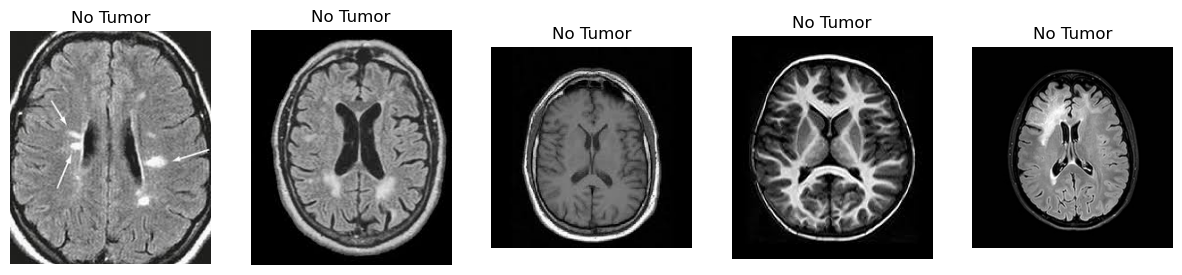

In [37]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Function to display sample images from a folder
def display_images(folder, label, n=5):
    # Get all image files from the folder
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
    # Select up to `n` images to display
    image_files = image_files[:n]
    
    # Create a figure
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_files):
        img = Image.open(img_path)  # Open the image
        plt.subplot(1, n, i + 1)    # Add a subplot
        plt.imshow(img, cmap='gray')  # Display the image
        plt.title(label)  # Title as the label
        plt.axis('off')   # Turn off axes
    plt.show()


# Display sample images from 'yes' and 'no'
print("Sample images from 'yes' (Tumor) dataset:")
display_images(yes_dir, label="Tumor")

print("Sample images from 'no' (No Tumor) dataset:")
display_images(no_dir, label="No Tumor")


In [38]:
image_paths = []
labels = []

# Process 'yes' folder
for filename in os.listdir(yes_dir):
    file_path = os.path.join(yes_dir, filename)
    if os.path.isfile(file_path):  # Ensure it's a file
        image_paths.append(file_path)
        labels.append(1)  # Label for tumor

# Process 'no' folder
for filename in os.listdir(no_dir):
    file_path = os.path.join(no_dir, filename)
    if os.path.isfile(file_path):  # Ensure it's a file
        image_paths.append(file_path)
        labels.append(0)  # Label for no tumor

# Create the dataframe
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Display the first few rows

data


,image_path,label
0,/Users/yannietchi/Desktop/comp-562-final-proje...,1
1,/Users/yannietchi/Desktop/comp-562-final-proje...,1
2,/Users/yannietchi/Desktop/comp-562-final-proje...,1
3,/Users/yannietchi/Desktop/comp-562-final-proje...,1
4,/Users/yannietchi/Desktop/comp-562-final-proje...,1
...,...,...
248,/Users/yannietchi/Desktop/comp-562-final-proje...,0
249,/Users/yannietchi/Desktop/comp-562-final-proje...,0
250,/Users/yannietchi/Desktop/comp-562-final-proje...,0
251,/Users/yannietchi/Desktop/comp-562-final-proje...,0


<h2> Data Augmentation</h2>

In [41]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

# Define data augmentation for grayscale images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to load and augment images
def augment_images(folder, label, augmentor, num_augments=3):
    data = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        if os.path.isfile(img_path):
            # Load and preprocess image
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img).reshape((1, img.size[1], img.size[0], 1))  # Reshape for augmentation
            
            # Append original image to data
            data.append({'image': img.squeeze(), 'label': label})

            # Generate augmented images
            aug_iter = augmentor.flow(img, batch_size=1)
            for _ in range(num_augments):
                aug_img = next(aug_iter)[0].squeeze()
                data.append({'image': aug_img, 'label': label})
    return data



# Augment images in both folders
yes_data = augment_images(yes_dir, 1, datagen, num_augments=3)  # Tumor label is 1
no_data = augment_images(no_dir, 0, datagen, num_augments=3)    # No-tumor label is 0

# Combine data into a DataFrame
data_augmented = yes_data + no_data
df_augmented = pd.DataFrame(data_augmented)

# Example: Display first few rows of the DataFrame
df_augmented


,image,label
0,"[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",1
1,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
2,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
3,"[[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...",1
4,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1
...,...,...
1007,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1008,"[[28, 29, 0, 2, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1009,"[[23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23...",0
1010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [42]:
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from PIL import Image
import os
import random

# Set the target size for images
target_size = (64, 64)

# Augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a DataFrame to store image and label
augmented_images = []

# Loop through the original 'yes' and 'no' folders and augment images
def augment_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Open the image
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = np.array(img)
            
            # Standardize shape to target size (e.g., 64x64)
            img_resized = resize(np.expand_dims(img, axis=-1), target_size).numpy()

            # Perform augmentation
            img_reshaped = img_resized.reshape((1,) + img_resized.shape)  # Reshape for augmentation
            it = datagen.flow(img_reshaped, batch_size=1)

            # Store augmented images and their labels
            for _ in range(5):  # Augment and store 5 versions per image
                augmented_img = next(it)[0].astype(np.uint8)  # Get the augmented image
                augmented_images.append([augmented_img, label])


# Augment images from 'yes' and 'no' folders
augment_images_from_folder(yes_dir, 1)  # Tumor label = 1
augment_images_from_folder(no_dir, 0)  # No tumor label = 0

# Convert to DataFrame
df_augmented = pd.DataFrame(augmented_images, columns=['image', 'label'])

# Show a sample from the dataframe (e.g., first 3 images)
df_augmented.head(3)




,image,label
0,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...",1
1,"[[[1], [1], [1], [1], [1], [1], [1], [1], [1],...",1
2,"[[[1], [1], [1], [1], [1], [1], [1], [1], [72]...",1


<h2> Baseline Model<h2>

Epoch 1/20
22/22 [==============================] - 3s 98ms/step - loss: 0.9539 - accuracy: 0.5188 - val_loss: 0.8761 - val_accuracy: 0.4855
Epoch 2/20
22/22 [==============================] - 2s 70ms/step - loss: 0.9124 - accuracy: 0.4971 - val_loss: 0.7874 - val_accuracy: 0.4855
Epoch 3/20
22/22 [==============================] - 3s 146ms/step - loss: 0.8499 - accuracy: 0.5173 - val_loss: 0.7505 - val_accuracy: 0.4855
Epoch 4/20
22/22 [==============================] - 3s 156ms/step - loss: 0.7921 - accuracy: 0.5217 - val_loss: 0.7309 - val_accuracy: 0.4855
Epoch 5/20
22/22 [==============================] - 3s 145ms/step - loss: 0.7746 - accuracy: 0.5592 - val_loss: 0.7178 - val_accuracy: 0.4855
Epoch 6/20
22/22 [==============================] - 3s 142ms/step - loss: 0.7690 - accuracy: 0.5376 - val_loss: 0.7072 - val_accuracy: 0.4855
Epoch 7/20
22/22 [==============================] - 3s 153ms/step - loss: 0.7293 - accuracy: 0.5983 - val_loss: 0.6973 - val_accuracy: 0.4971
Epoch 8/

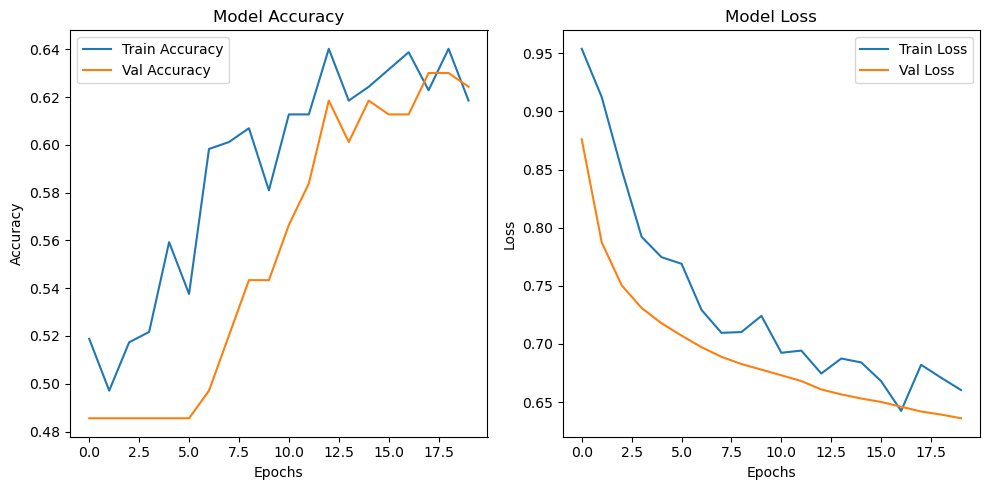

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Assuming df_augmented is already created as shown in the previous steps
X = np.array([np.expand_dims(img, axis=-1) for img in df_augmented['image']])  # Shape: (n_samples, 64, 64, 1)
y = np.array(df_augmented['label'])  # Labels: 0 or 1

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model architecture
def create_cnn_model(input_shape=(64, 64, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification (tumor vs non-tumor)
    
    model.compile(optimizer=Adam(learning_rate= 0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model



def baseline_cnn_model(input_shape=(64, 64, 1)):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Global average pooling to reduce dimensions and avoid overfitting
    model.add(GlobalAveragePooling2D())
    
    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # For binary classification (tumor vs non-tumor)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


# Create CNN model
model = baseline_cnn_model()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

# Plot the learning curves
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


<h2> Test<h3>

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates a classification model using various metrics, confusion matrix, and ROC curve.
    
    Parameters:
    - model: Trained classification model (e.g., CNN, SVM, etc.)
    - X_test: Test data features
    - y_test: True labels for the test data
    - threshold: Probability threshold for classification (default is 0.5 for binary classification)
    
    Returns:
    - None (prints evaluation metrics and plots confusion matrix & ROC curve)
    """
    # Predict probabilities or labels
    y_pred_prob = model.predict(X_test)
    
    # For binary classification, convert probabilities to labels
    if y_pred_prob.shape[1] == 1:  # Binary classification
        y_pred = (y_pred_prob > threshold).astype(int)
    else:  # For multi-class classification
        y_pred = np.argmax(y_pred_prob, axis=1)

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a 1x2 subplot layout (side-by-side)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Tumor', 'Tumor'], yticklabels=['Non-Tumor', 'Tumor'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # ROC Curve
    if y_pred_prob.shape[1] == 1:  # Binary classification
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        axes[1].plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='lower right')
    else:
        axes[1].text(0.5, 0.5, "ROC curve is only applicable for binary classification.", horizontalalignment='center', verticalalignment='center', fontsize=12)
        axes[1].axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()



6/6 [==============================] - 0s 15ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.43      0.54        89
           1       0.58      0.83      0.68        84

    accuracy                           0.62       173
   macro avg       0.65      0.63      0.61       173
weighted avg       0.66      0.62      0.61       173



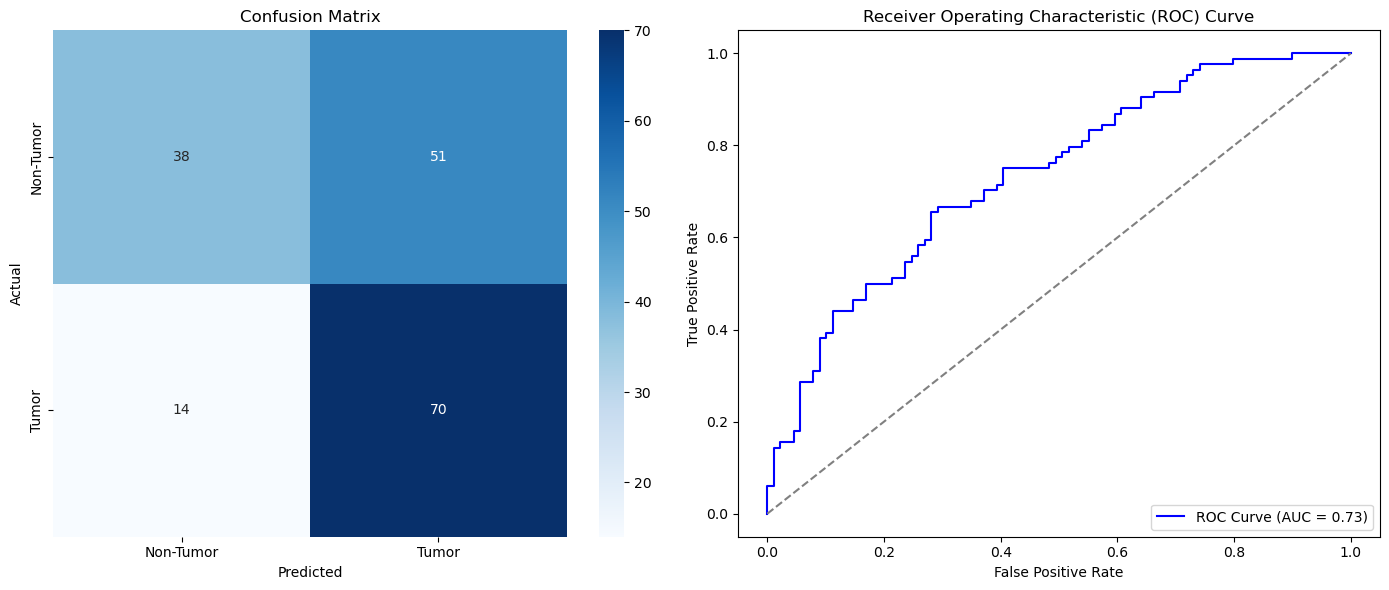

In [54]:
evaluate_model(model,X_val,y_val)